# 2. EDA

This section regards the Explanatory Data Analysis, which consists in different parts:
- basic EDA on features
- insights on reviews and time periods
- sentiment - review relationship
- WordClouds
- N-gram analysis

In [323]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob
import nltk
from nltk.stem  import WordNetLemmatizer
import cufflinks as cf

In [319]:
pd.set_option("max_colwidth", None)
plt.style.use('ggplot')

In [322]:
df = pd.read_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/clean_reviews.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day
0,good sound seem decent build quality good sound happy purchase,good sound. seem decent build quality and good sound. very happy with purchase.,good sound,seem decent build quality and good sound. very happy with purchase.,5,Positive,2023,5,28
1,not realise bad audio setup considering used quite respectable setup many years ago feel trap using bluetooth speakers leave lot desired price provide perfect audio experience filling 3x3m room hardly auditorium quality amazing feel like subwoofer genres average listening experience without neighbours complaining beautiful almost brings tear eye,"i didn't realise how bad my audio setup was. considering i used to have quite a respectable setup many years ago i've feel into a trap of using bluetooth speakers which leave a lot to be desired. for the price these provide a perfect audio experience. now i'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. i do feel like i could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. almost brings a tear to my eye.",i didn't realise how bad my audio setup was,"considering i used to have quite a respectable setup many years ago i've feel into a trap of using bluetooth speakers which leave a lot to be desired. for the price these provide a perfect audio experience. now i'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. i do feel like i could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. almost brings a tear to my eye.",5,Positive,2023,5,27
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26


- Review: title + content
- Clean review: it is the Review column without emoticons and punctuation

## Exploratory Data Analysis

### Basic and quick EDA on some features

In [205]:
# column types
df.dtypes

Review          object
Clean Review    object
Rating           int64
Sentiment       object
Year             int64
Month            int64
Day              int64
Title           object
Content         object
dtype: object

In [206]:
# NA check
df.isna().sum()

Review          0
Clean Review    0
Rating          0
Sentiment       0
Year            0
Month           0
Day             0
Title           0
Content         9
dtype: int64

In [207]:
# empty value check
len(df[df['Title'] == ""]), len(df[df['Sentiment'] == ""])

(0, 0)

Looks like we have 0 missing & empty values for the columns.

In [208]:
for col in ['Title', 'Rating', 'Content']:
    print(f'---------{col.upper()}---------')
    print(df[col].describe())
    print("\n")

---------TITLE---------
count            740
unique           653
top       five stars
freq               9
Name: Title, dtype: object


---------RATING---------
count    740.000000
mean       4.481081
std        1.100335
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64


---------CONTENT---------
count               731
unique              728
top       great product
freq                  3
Name: Content, dtype: object




On a total of 740 reviews, We have 666 unique titles and 730 unique review contents. The value **top** and **freq** indicate the most frequent value and its frequency. Basically **'Five Stars'** appears 9 times in the Title column.

In [209]:
# checking relative frequencies for each sentiment
df['Sentiment'].value_counts()/df.shape[0]

Positive    0.868919
Negative    0.089189
Neutral     0.041892
Name: Sentiment, dtype: float64

### Insights on reviews and time periods

In these next graphs I will present the number of reviews alng with their sentiment for each year, month and day. To make these histograms i grouped the review counts by year, month and day to then plot each value.

I assume that there will be no correlation between the time period and the sentiment, therefore the most impactful plots will be the first 3.

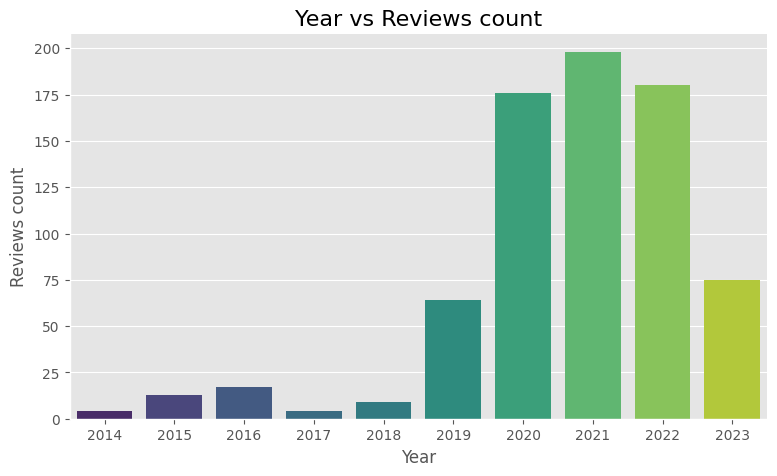

In [211]:
plt.figure(figsize=(9, 5))

year = pd.DataFrame(df.groupby('Year')['Review'].count()).reset_index()
year['Year'] = year['Year'].astype('int64')
year.sort_values(by=['Year'])

sns.barplot(x="Year", y="Review", data=year, palette='viridis', estimator=sum)
plt.title('Year vs Reviews count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)

sns.despine()  # Remove the top and right spines
plt.show()

From this barplot we deduct that the boom of the product has been between 2019 and 2020, even if there were some reviews from 2014 onwards. Obviously the 2023 reviews are much less than the other recent years.

Also, as a home product, the speakers saw an exponential increase in sales maybe due to the COVID-19 pandemic, and this led also to more reviews.

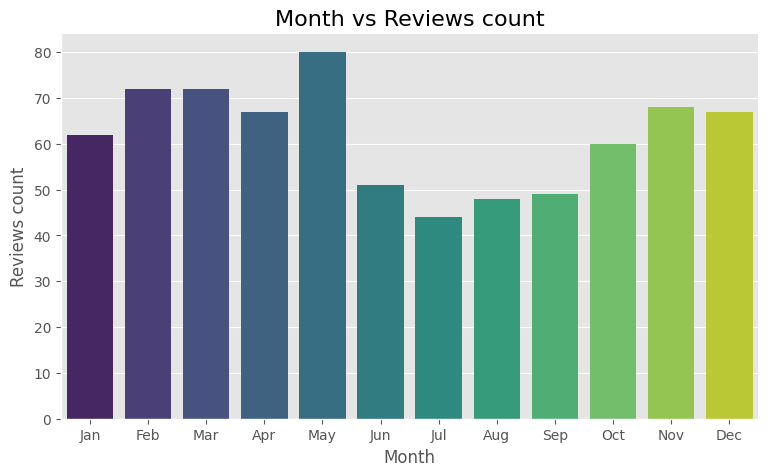

In [212]:
plt.figure(figsize=(9, 5))

month = pd.DataFrame(df.groupby('Month')['Review'].count()).reset_index()
month['Month'] = month['Month'].astype('int64')
month.sort_values(by=['Month'])
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.barplot(x="Month", y="Review", data=month, palette='viridis')
plt.title('Month vs Reviews count', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.xticks(range(len(month_labels)), month_labels)      # to put the labels

sns.despine()  # Remove the top and right spines
plt.show()

Looks like there tends to be less reviews during summer time!

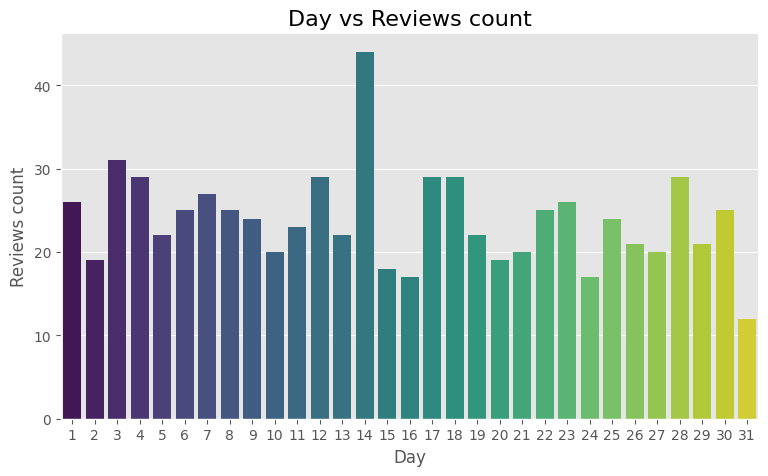

In [213]:
plt.figure(figsize=(9, 5))
day = pd.DataFrame(df.groupby('Day')['Review'].count()).reset_index()

sns.barplot(x="Day", y="Review", data=day, palette='viridis')
plt.title('Day vs Reviews count', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)

sns.despine()  # Remove the top and right spines
plt.show()

The review counts are more or less uniformly distributed, unless from the day 14 of the month. There isn't that much variance between the days. But there is a for sure a little drop at the end of month.

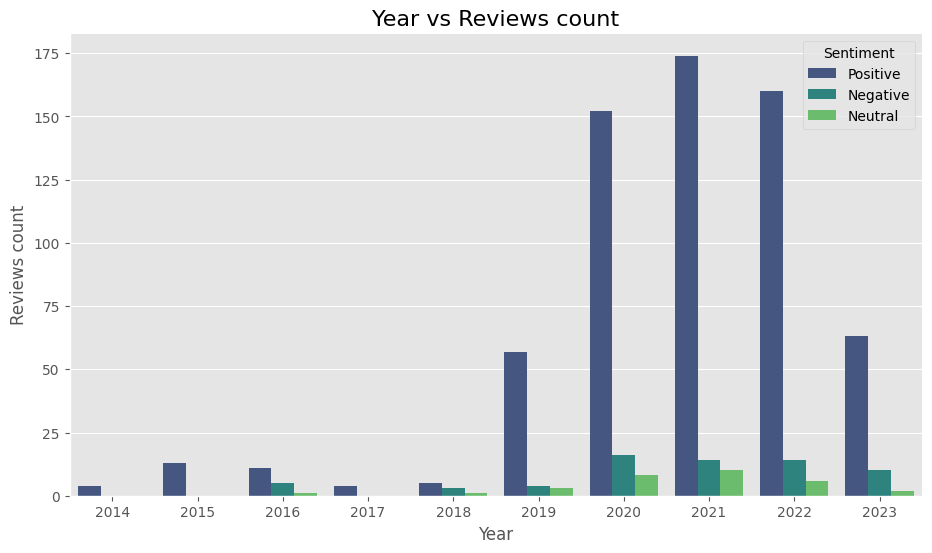

In [214]:
plt.figure(figsize=(11, 6))
Year = pd.DataFrame(df.groupby(['Year', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Year", y="Review", hue='Sentiment', data=Year, palette='viridis')
plt.title('Year vs Reviews count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)

sns.despine()  # Remove the top and right spines
plt.show()

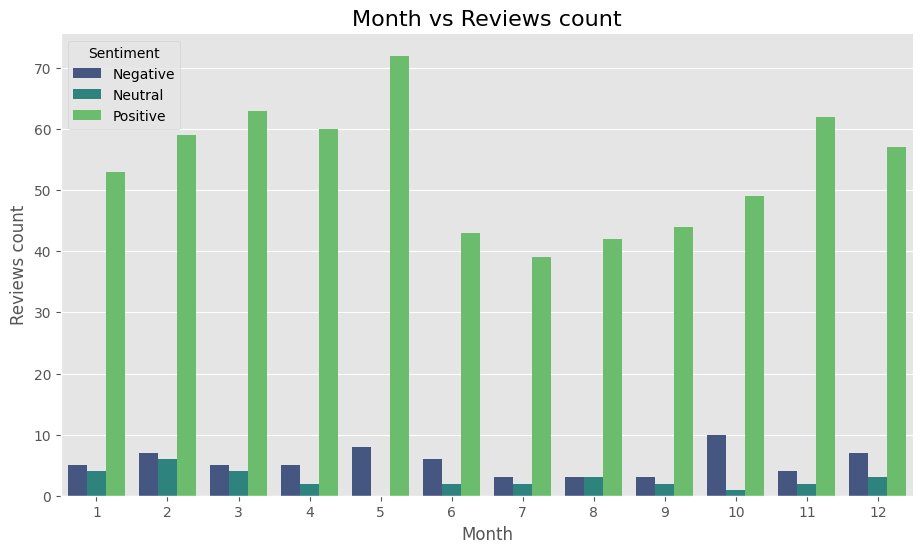

In [215]:
plt.figure(figsize=(11, 6))
Month = pd.DataFrame(df.groupby(['Month', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Month", y="Review", hue='Sentiment', data=Month, palette='viridis')
plt.title('Month vs Reviews count', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)

sns.despine()  # Remove the top and right spines
plt.show()

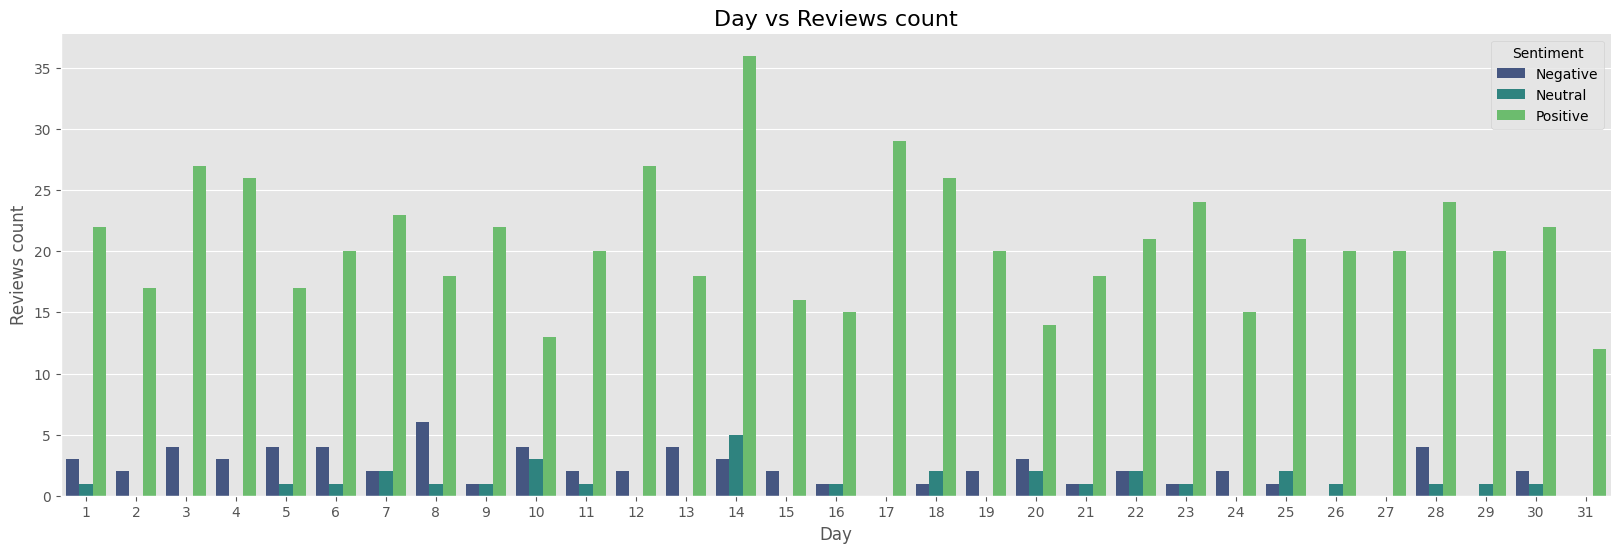

In [216]:
plt.figure(figsize=(20, 6))
day = pd.DataFrame(df.groupby(['Day', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Day", y="Review", hue='Sentiment', data=day, palette='viridis')
plt.title('Day vs Reviews count', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)

sns.despine()  # Remove the top and right spines
plt.show()

These plots confirm my initial assumption, showing that there is absolutely no correlation between the review's sentiment and the time in which the user writes the feedback.

### Sentiment - Review Relationship

I assume to find longer reviews for higher polarities: it means that a higly satisfied customer is more incline of writing a long and positive review, and the same thing for a customer which is highly unsatistifed with the product. This section is important since I will add some more features.

Let's see if my assumption is right. 

**New features:**
- Polarity: Using Textblob for figuring out the rate of sentiment. It is between [-1,1] where -1 is negative and 1 is positive polarity
- Review length: length of the review, which includes each letters and spaces
- Word length: how many words are there in every review (including emoticons and punctuation)

In [217]:
df['Polarity'] = df['Clean Review'].map(lambda text: TextBlob(text).sentiment.polarity)
df['Review Length'] = df['Clean Review'].astype(str).apply(len)
df['Word Count'] = df['Clean Review'].apply(lambda x: len(str(x).split()))

In [218]:
df.head(1)

,Review,Clean Review,Rating,Sentiment,Year,Month,Day,Title,Content,Polarity,Review Length,Word Count
0,good sound. seem decent build quality good sound. happy purchase.,good sound seem decent build quality good sound happy purchase,5,Positive,2023,5,28,good sound,seem decent build quality and good sound. very happy with purchase.,0.527778,62,10


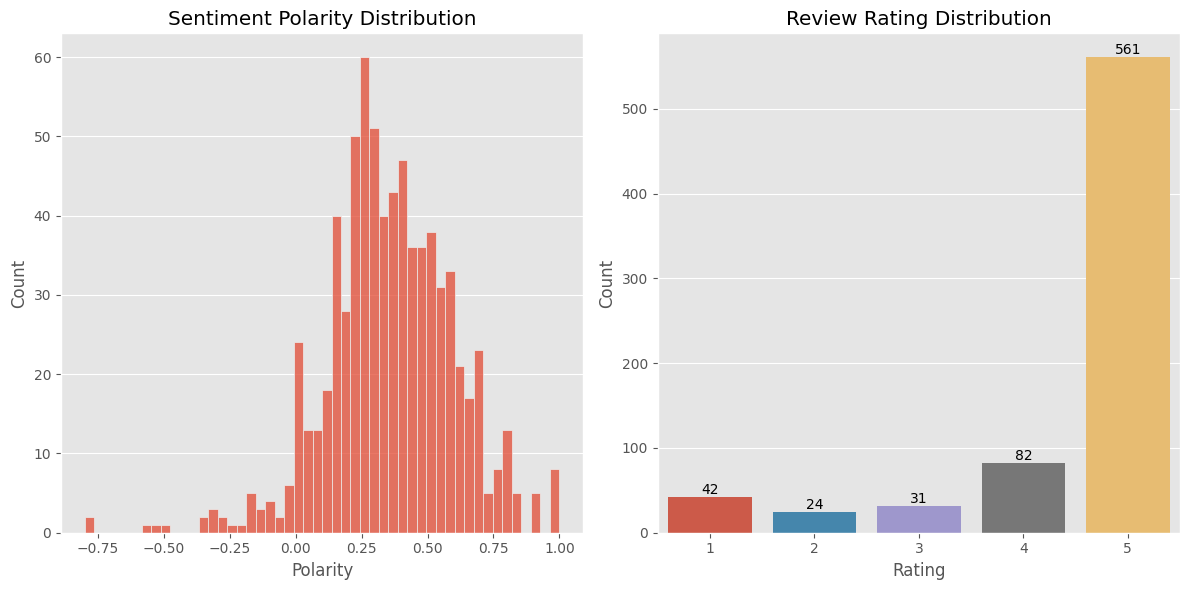

In [244]:
# Rating distribution along with Sentiment polarity (Textblob baseline)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Ratings
sns.countplot(x=df['Rating'], ax=axs[1])
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Count')
axs[1].set_title('Review Rating Distribution')
for i, count in enumerate(df['Rating'].value_counts().sort_index()):
    axs[1].annotate(count, (i, count), ha='center', va='bottom')

# Polarity
sns.histplot(df['Polarity'], bins=50, kde=False, ax=axs[0])
axs[0].set_xlabel('Polarity')
axs[0].set_ylabel('Count')
axs[0].set_title('Sentiment Polarity Distribution')
axs[0].grid(axis='x')

plt.tight_layout()
plt.show()

Very biased towards positive reviews.

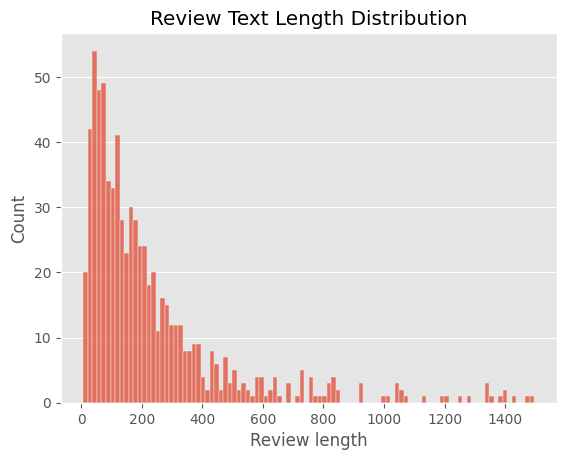

In [257]:
# Review Length Distribution
sns.histplot(df['Review Length'], bins=100)
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Review Text Length Distribution')
plt.grid(axis='x')
plt.show()

Highly positively skewed distribution where most of the lengths falls between 0-1000.

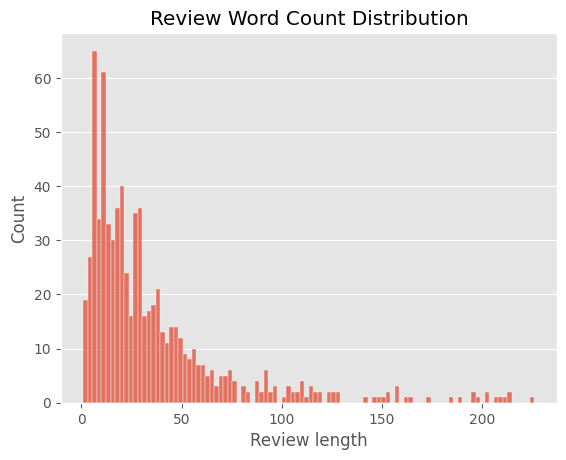

In [258]:
# Review word count Distribution
sns.histplot(df['Word Count'], bins=100)
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Review Word Count Distribution')
plt.grid(axis='x')
plt.show()

As previously, but the reviews have on average 0 to 50 words.

### WordClouds

In this section are presented 3 different WordClouds, one for each sentiment (Postive, Negative, Neutral). Which words are the most "popular" among every type of sentiment?

### N-gram analysis

---

## NLTK

In [ ]:
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download("stopwords")
# nltk.download('tagsets')
# nltk.download('wordnet')

In [ ]:
example = df['Content'][11]
print(example)

bought a pair of these for my daughter, so good i kept them and ordered another pair :-)


In [ ]:
tokens = nltk.word_tokenize(example)
tokens

['bought',
 'a',
 'pair',
 'of',
 'these',
 'for',
 'my',
 'daughter',
 ',',
 'so',
 'good',
 'i',
 'kept',
 'them',
 'and',
 'ordered',
 'another',
 'pair',
 ':',
 '-',
 ')']

Tokenized result: basically to convert a sentence into a format which is understable by the computer a.k.a. feature vector. As we can see nltk is smart because it detects the won't word and splits it into 'wo' and "n't".

Now find the part of speech for each of these words:

In [ ]:
tag = nltk.pos_tag(tokens)
tag

[('bought', 'VBD'),
 ('a', 'DT'),
 ('pair', 'NN'),
 ('of', 'IN'),
 ('these', 'DT'),
 ('for', 'IN'),
 ('my', 'PRP$'),
 ('daughter', 'NN'),
 (',', ','),
 ('so', 'RB'),
 ('good', 'JJ'),
 ('i', 'NN'),
 ('kept', 'VBD'),
 ('them', 'PRP'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('another', 'DT'),
 ('pair', 'NN'),
 (':', ':'),
 ('-', ':'),
 (')', ')')]

What is the meaning of these tags?

In [ ]:
# nltk.help.upenn_tagset()

These are the most important:

| Tag  | Meaning       |
|------|---------------|
| JJ   | Adjectives    |
| NN   | Nouns         |
| RB   | Adverbs       |
| PRP  | Pronouns      |
| VB   | Verbs         |

Putting now these tags - part of speech into entities.

In [ ]:
entities = nltk.chunk.ne_chunk(tag)
entities.pprint()       # pretty print nltk function

(S
  bought/VBD
  a/DT
  pair/NN
  of/IN
  these/DT
  for/IN
  my/PRP$
  daughter/NN
  ,/,
  so/RB
  good/JJ
  i/NN
  kept/VBD
  them/PRP
  and/CC
  ordered/VBD
  another/DT
  pair/NN
  :/:
  -/:
  )/))


**LEMMATIZING:**  A lemma is a word that represents a whole group of words, so lemmatizing consists in reducing  words to their core meaning (doing -> do).

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmatizer

<WordNetLemmatizer>

In [ ]:
lemmatizer.lemmatize("bought")

'bought'

In [ ]:
lemmatized_example = [lemmatizer.lemmatize(token) for token in tokens]
lemmatized_example

['bought',
 'a',
 'pair',
 'of',
 'these',
 'for',
 'my',
 'daughter',
 ',',
 'so',
 'good',
 'i',
 'kept',
 'them',
 'and',
 'ordered',
 'another',
 'pair',
 ':',
 '-',
 ')']

In [ ]:
tokens

['bought',
 'a',
 'pair',
 'of',
 'these',
 'for',
 'my',
 'daughter',
 ',',
 'so',
 'good',
 'i',
 'kept',
 'them',
 'and',
 'ordered',
 'another',
 'pair',
 ':',
 '-',
 ')']

----

## VADER


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

Compound is an aggregation of the 3, goes from -1 to 1.

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
print(example)
print(sia.polarity_scores(example))

bought a pair of these for my daughter, so good i kept them and ordered another pair :-)
{'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'compound': 0.722}


In [ ]:
# run on entire dataset
results = {}
for row in df:
    # text = row['Content']
    # Id = row
    # results['Id'] = sia.polarity_scores(text)
    print(row)

Title
Content
Clean Content
Review
Rating
Sentiment
Year
Month
Day


In [ ]:
# run on entire dataset
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Content']
    Id = i
    results[Id] = sia.polarity_scores(text)

  0%|          | 0/740 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

Is this in line with what we expect? If the rating is 5-4, is the rating positive?

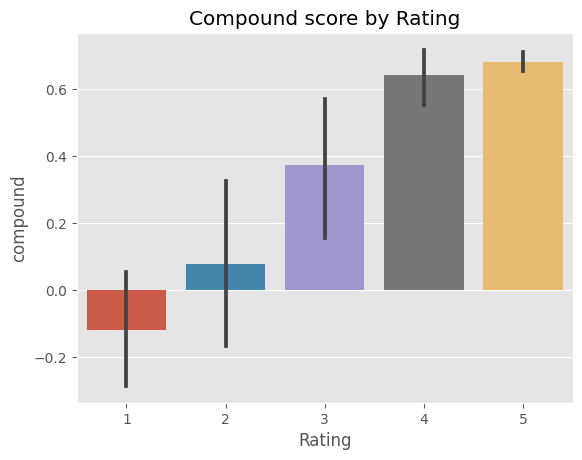

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

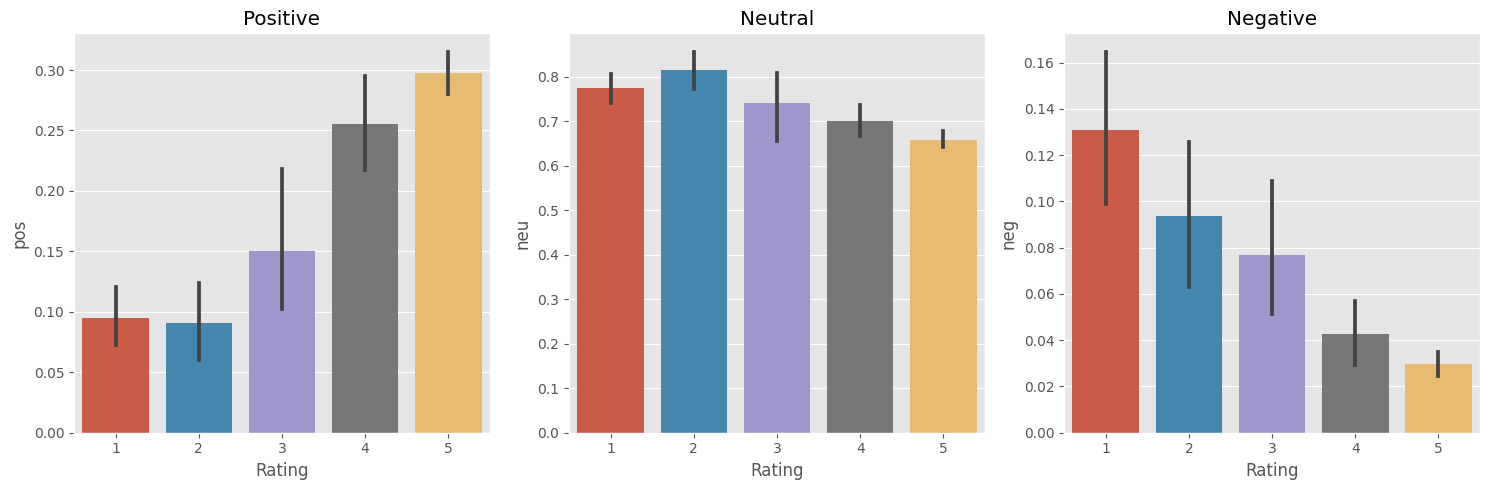

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

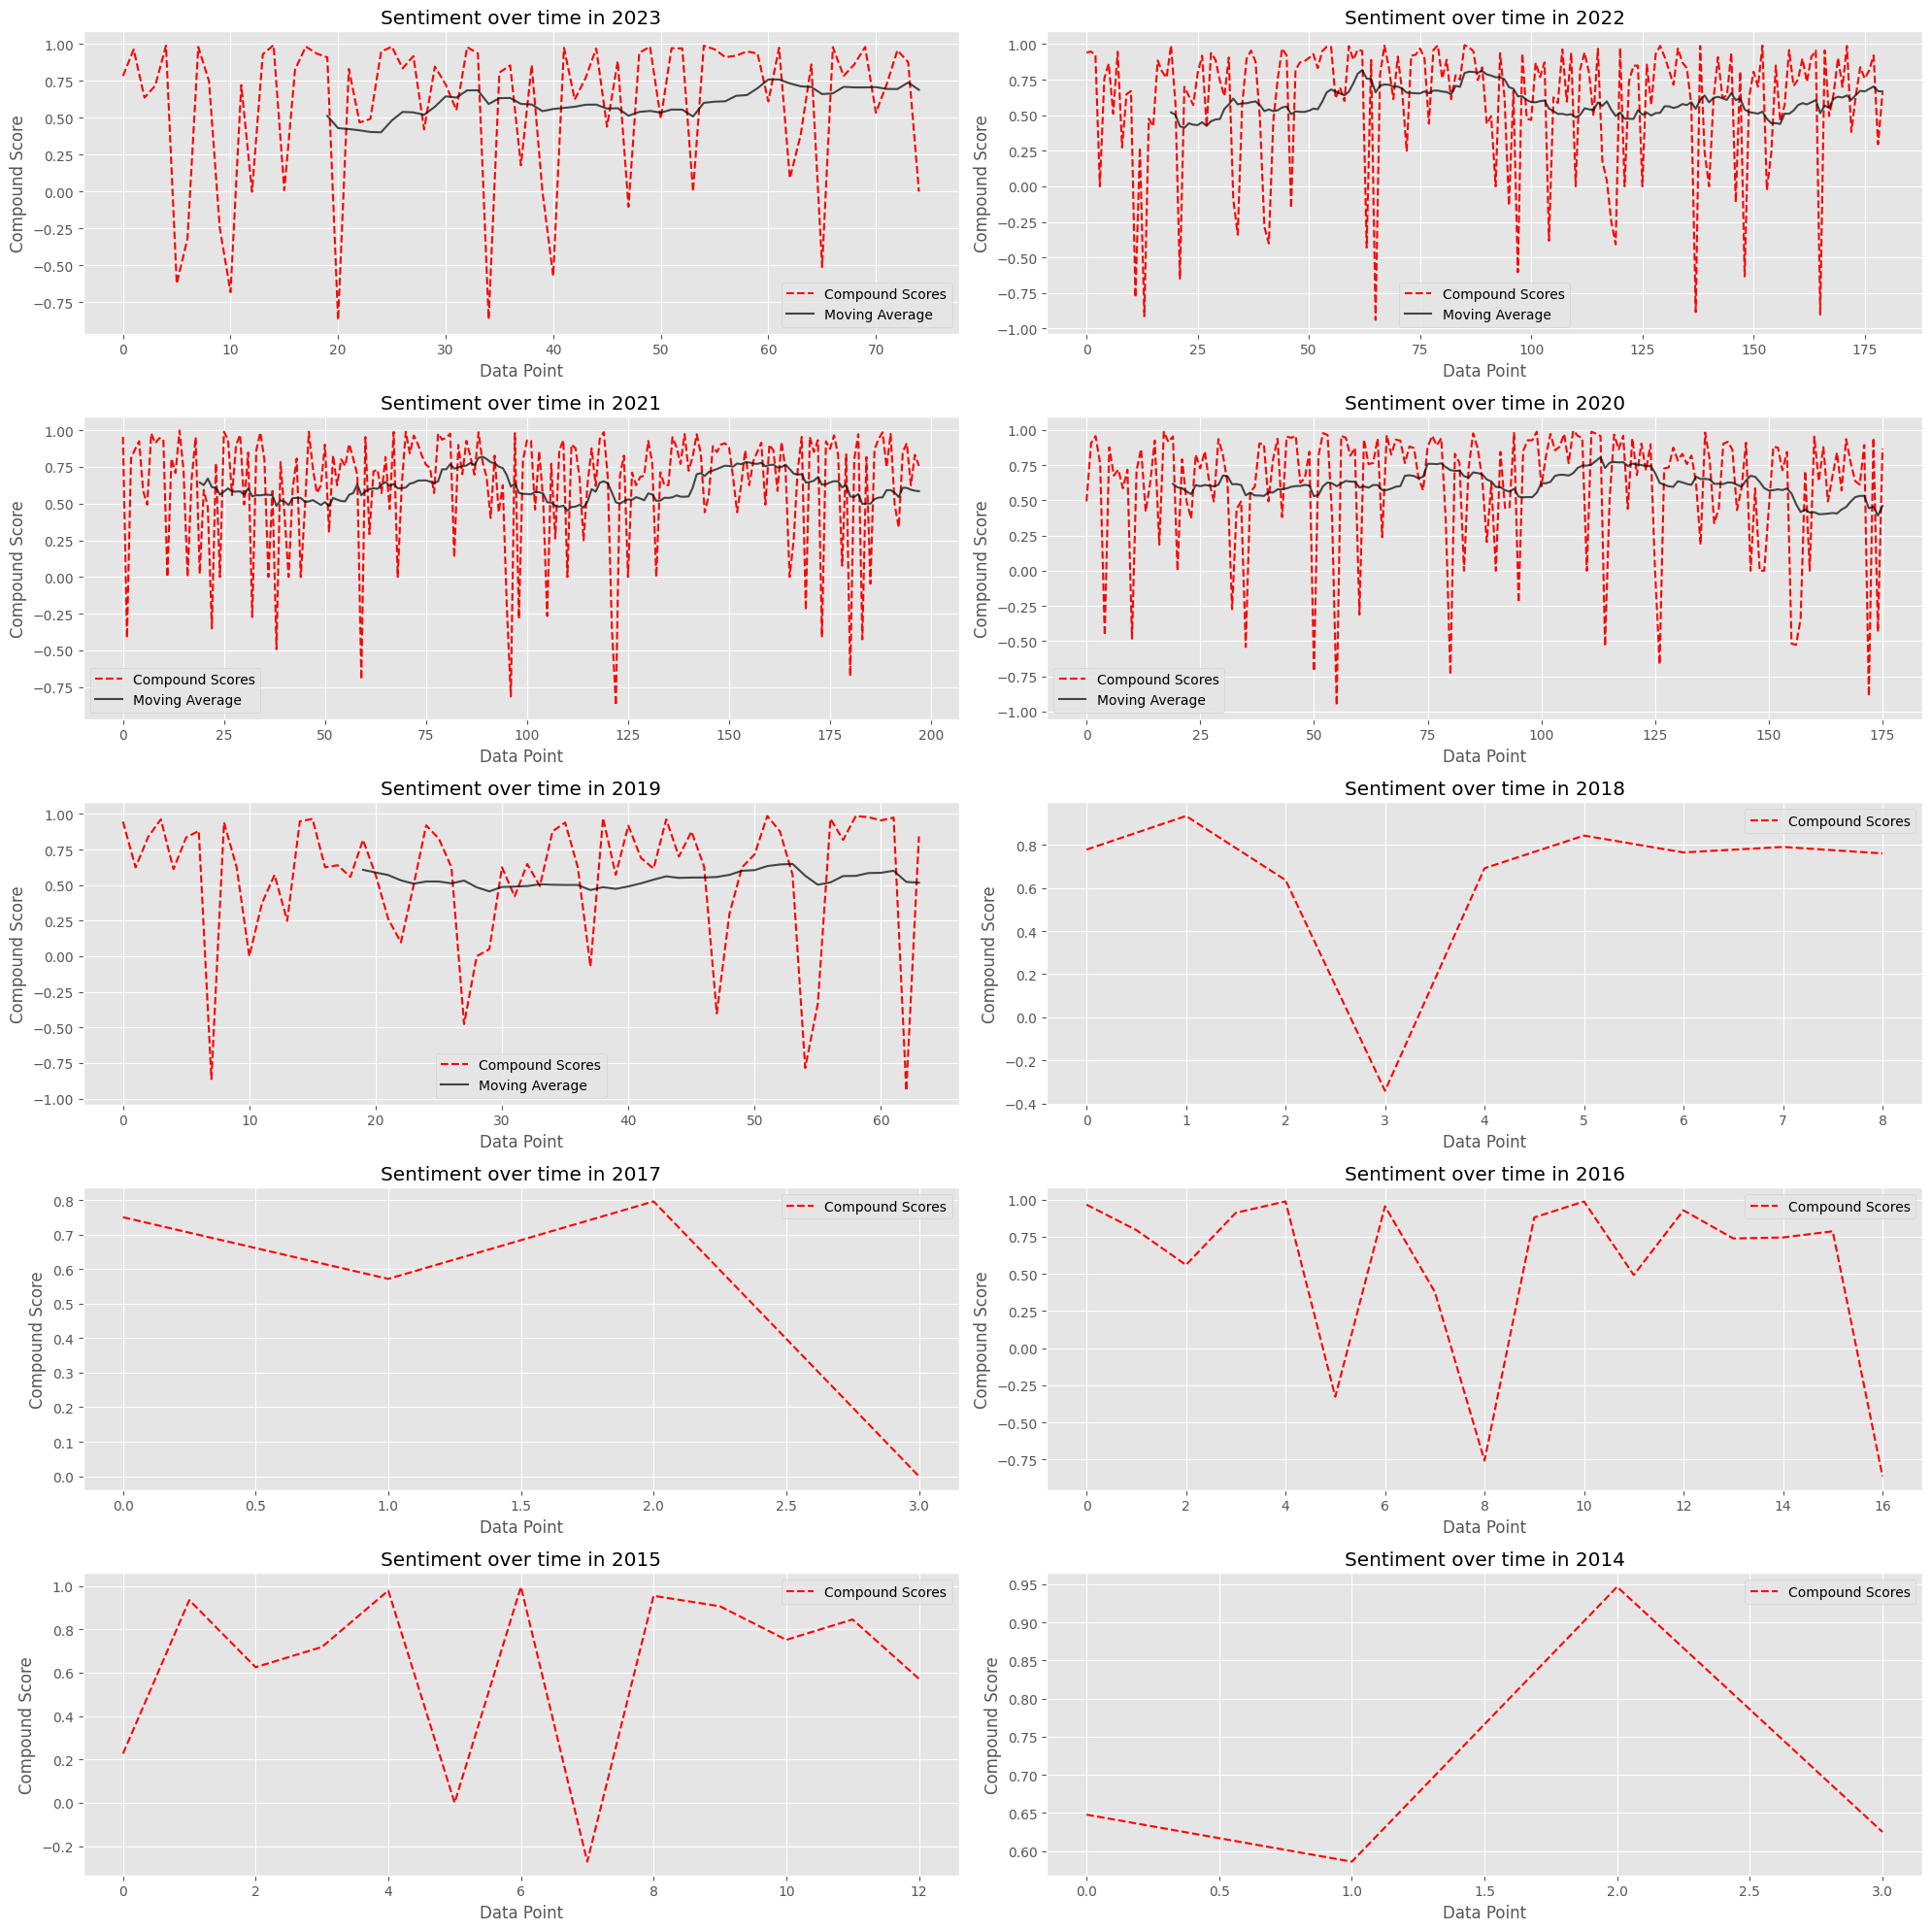

In [ ]:
# not right since do not have days
# barplots of each year are better

fig, ax = plt.subplots(5, 2, figsize=(20, 20))
ax = ax.flatten()

for i, year in enumerate(vaders['Date'].dt.year.unique()):  # Use 'dt.year' to extract the year from the 'Date' column
    # Filter data for the year
    year_data = vaders[vaders['Date'].dt.year == year]['compound'].tolist()
    # Calculate moving average
    if len(year_data) > 60:         # 60 chosen by inspecting how many observations i had for each year
        moving_avg = pd.Series(year_data).rolling(window=20).mean()

        ax[i].plot(year_data, color="red", linestyle='dashed', label='Compound Scores')
        ax[i].plot(moving_avg, color='black', alpha=0.7, label='Moving Average')
        ax[i].set_title(f'Sentiment over time in {year}')
        ax[i].set_xlabel('Data Point')
        ax[i].set_ylabel('Compound Score')
        ax[i].legend()
    
    else:
        ax[i].plot(year_data, color="red", linestyle='dashed', label='Compound Scores')
        ax[i].set_title(f'Sentiment over time in {year}')
        ax[i].set_xlabel('Data Point')
        ax[i].set_ylabel('Compound Score')
        ax[i].legend()

plt.tight_layout()
plt.show()


## RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline = ('phrase')